# 별사탕 프로젝트_EX5.나랑 닮은 연예인 찾기

박창근님 우수 노드 참고

https://github.com/LilPark/AIFFEL_project/blob/main/Exploration_05/%5BE-05%5DFaceEmbedding.ipynb

## 0. 사진 모으기

누군가가 줬는데 기억이 안나지만 하여튼 데이터 셋 있음.


## 1. 얼굴 영역 자르기

In [1]:
import face_recognition
import os
from PIL import Image

dir_path = os.getenv('HOME')+'/aiffel/face_embedding/celebrity2'
file_list = os.listdir(dir_path)

print(len(file_list))

139


In [2]:
def get_gropped_face(image_file):
    image = face_recognition.load_image_file(image_file)
    face_locations = face_recognition.face_locations(image)
    a, b, c, d = face_locations[0]
    cropped_face = image[a:c,d:b,:]
    
    return cropped_face

In [3]:
def save_cropped_face(dir_path):
    file_list = os.listdir(dir_path)
    
    for file in file_list:
        try:
            img_path = os.path.join(dir_path, file)
            face = get_gropped_face(img_path)
            pillow_image = Image.fromarray(face)
            path_to_save = os.path.join(save_path, file)
            pillow_image.save(path_to_save)
            
        except:
            os.remove(img_path)
            print(file, "was removed")

    print('Cropped images are saved')

save_path = os.getenv('HOME')+'/aiffel/face_embedding/images_cropped'
save_cropped_face(dir_path)

Cropped images are saved


In [4]:
import glob

files = glob.glob(os.path.join(save_path, '*.png'))
for file in files:
    if not os.path.isdir(file):
        src = os.path.splitext(file)
        os.rename(file, src[0] + '.jpg')

In [5]:
files = glob.glob(os.path.join(save_path, '*.jpeg'))
for file in files:
    if not os.path.isdir(file):
        src = os.path.splitext(file)
        os.rename(file, src[0] + '.jpg')

## 3. 얼굴 영역 Embedding 추출

In [6]:
def get_face_embedding(face):
    return face_recognition.face_encodings(face)

In [7]:
def get_face_embedding_dict(dir_path):
    file_list = os.listdir(dir_path)
    embedding_dict = {}
    
    for file in file_list:
        img_path = os.path.join(dir_path, file)
        face = get_gropped_face(img_path)
        embedding = get_face_embedding(face)
        if len(embedding) > 0:  # 얼굴영역 face가 제대로 detect되지 않으면 len(embedding)==0인 경우가 발생하므로 
            # os.path.splitext(file)[0]에는 이미지파일명에서 확장자를 제거한 이름이 담깁니다. 
            embedding_dict[os.path.splitext(file)[0]] = embedding[0]
    
    print("Embedding dictionary was made")
    return embedding_dict

# 내 사진의 임베딩 딕셔너리 출력
embedding_dict = get_face_embedding_dict(dir_path)
embedding_dict['mypicture']

Embedding dictionary was made


array([-0.05614071,  0.08546083,  0.08571999, -0.03129164, -0.0691903 ,
       -0.01034158, -0.05246478, -0.06150456,  0.04958273,  0.02565125,
        0.28512442, -0.06347173, -0.20637415, -0.11066778, -0.03804232,
        0.16622224, -0.18999961, -0.12924191, -0.06915338, -0.06377035,
        0.07233042, -0.00342249,  0.07910792, -0.05184961, -0.09237448,
       -0.34668496, -0.09369887, -0.103137  ,  0.17473078, -0.09906468,
       -0.00459296, -0.01999699, -0.19298932, -0.05330974,  0.05427407,
        0.07159205, -0.03213133, -0.11881617,  0.2096525 , -0.01888335,
       -0.19471098,  0.05722161,  0.05555467,  0.21734786,  0.25515339,
        0.05065795,  0.03996435, -0.12141792,  0.06222285, -0.12121578,
        0.07835503,  0.16555561,  0.05272865,  0.08484897, -0.02634016,
       -0.06443399,  0.0548382 ,  0.08579696, -0.17451188,  0.00476983,
        0.12158722, -0.07258998, -0.0374055 , -0.04556199,  0.08827312,
        0.01320499, -0.05917786, -0.25023559,  0.13525337, -0.16

## 4. 연예인들의 얼굴과 거리 비교하기

In [8]:
import numpy as np

def get_distance(name1, name2):
    return np.linalg.norm(embedding_dict[name1]-embedding_dict[name2], ord=2)

print(get_distance('mypicture', 'mypicture1'))

0.42152932015909694


In [9]:
def get_sort_key_func(name1):
    def get_distance_from_name1(name2):
        return get_distance(name1, name2)
    return get_distance_from_name1

In [10]:
import pandas as pd

def get_nearest_face(name, top=6):
    sort_key_func = get_sort_key_func(name)
    sorted_faces = sorted(embedding_dict.items(), key=lambda x:sort_key_func(x[0]))
    
    rank, name, dist = [], [], []
    idx = 1
    
    for i in range(top+1):
        if i == 0 :
            continue
        elif sorted_faces[i][0].startswith('mypicture'):
            continue
        else:
            rank.append(idx)
            name.append(sorted_faces[i][0])
            dist.append(sort_key_func(sorted_faces[i][0]))
            idx += 1
    
    data = {'Rank': rank, 'Name': name, 'Distance': dist}
    return pd.DataFrame(data)

In [11]:
get_nearest_face('mypicture')

,Rank,Name,Distance
0,1,문재인,0.482363
1,2,나영석,0.508353
2,3,봉준호,0.518314
3,4,이경규,0.519889
4,5,금난새,0.538397


In [12]:
# 다른 사진으로 테스트
get_nearest_face('mypicture1')

,Rank,Name,Distance
0,1,문재인,0.547837
1,2,봉준호,0.580188
2,3,나영석,0.581902
3,4,이만기,0.605701
4,5,이연복,0.606752


## 시각화

In [13]:
df_1 = get_nearest_face('mypicture')
df_1['Similarity'] = 1 - df_1['Distance']
df_1['Score'] = (df_1['Similarity'] * 100).round().astype(int)
df_1

,Rank,Name,Distance,Similarity,Score
0,1,문재인,0.482363,0.517637,52
1,2,나영석,0.508353,0.491647,49
2,3,봉준호,0.518314,0.481686,48
3,4,이경규,0.519889,0.480111,48
4,5,금난새,0.538397,0.461603,46


In [14]:
df_2 = get_nearest_face('mypicture1')
df_2['Similarity'] = 1 - df_2['Distance']
df_2['Score'] = (df_2['Similarity'] * 100).round().astype(int)
df_2

,Rank,Name,Distance,Similarity,Score
0,1,문재인,0.547837,0.452163,45
1,2,봉준호,0.580188,0.419812,42
2,3,나영석,0.581902,0.418098,42
3,4,이만기,0.605701,0.394299,39
4,5,이연복,0.606752,0.393248,39


In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def get_nearest_image(name):
    df = get_nearest_face(name)
    df['Similarity'] = 1 - df['Distance']
    df['Score'] = (df['Similarity'] * 100).round().astype(int)
    
    fig = plt.figure(figsize=(10, 5))
    rows, cols = 1, 6
    i = 1
    
    name_list = [name] + list(df['Name'])
    score_list = ['My Photo'] + list(df['Score'])
    
    for name in name_list:
        if i == 7:
            break
        dir_path = os.getenv('HOME')+'/aiffel/face_embedding/images_cropped'
        img_path = os.path.join(dir_path, name + '.jpg')
        img = mpimg.imread(img_path)
        ax = fig.add_subplot(rows, cols, i)
        plt.imshow(img)
        plt.axis("off")
        ax.set_title(score_list[i-1])
        i += 1

    plt.show()

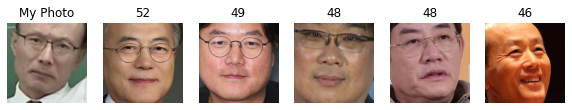

In [16]:
get_nearest_image('mypicture')

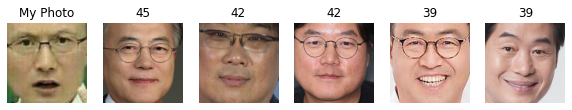

In [19]:
get_nearest_image('mypicture1')

# 회고



- 이미지 크롭할 때 해당 images_cropped 폴더가 있는지 확인도 안하고 바로 코드 실행했더니 크롭된 이미지들이 다 삭제가 되고 결과물도 없는 상태가 되었다. 그래서 다시 파일을 업로드 하는 과정을 보내며 시간을 보냈다;

- 내 사진의 임베딩 딕셔너리 출력하는 과정이 생각보다 오래 걸려서 자고 일어났다.

- 내 사진을 수학강사 한석원을 넣어서 돌려봤는데(ㅋㅋㅋㅋㅋ), 안경낀 이미지라서 그런지 결과가 안경을 낀 사람들위주로 나왔다.
- 안경이 없는 이미지는 좀 다르게 나오려나 한 번 돌려봐야겠다.